# The outline of the work

First, I will download and prepare the dataset inside Google Drive.
I will use the same dataset for both the tasks


*   Image Reconstruction
*   Image Captioning




In [23]:
import pandas as pd

import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision.datasets.utils import download_url


#import optim 
import torch.optim as optim



import numpy as np

COLAB = False

In [2]:
if COLAB:
    #from google.colab import drive
    drive.mount('/content/drive')


In [3]:
if COLAB:
    !mkdir train
    !mkdir ./train/images
    flickrImagePath = "./train/images"

In [16]:
flickrImagePath = "./train/images"

In [17]:
epochs = 8
imgChannels = 3
imgSize = 256
numFeatures = 4
learningRate = 2e-4
batchSize = 8
numWorkers = 2


# Download the dataset and prepare the files

In [6]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [47]:
from itertools import filterfalse

from datasets import load_dataset

downloadDataset = True
saveDataset = False
if COLAB:
  if downloadDataset:
    print("DOWNLOADING DATASET")
    dataset = load_dataset("nlphuji/flickr30k")["test"] #it downloads it as a dict that contains a single dict named dict
    dataset = dataset.to_pandas()
    dataset["image"] = dataset["image"].apply(lambda x: x["bytes"])
    if saveDataset:
      print("SAVING DATASET")
      dataset.to_pickle("./drive/MyDrive/stitching/train/dataset.pkl")
  else:
    print("LOADING DATASET")
    dataset = pd.read_pickle("./drive/MyDrive/stitching/train/dataset.pkl")
    dataset["image"] = dataset["image"].apply(lambda x: x["bytes"])


  print("DATASET READY")
  dataset.head(5)

In [48]:
dataset

Devo salvare le immagini e il testo come file separati e non come dataframe.

In [49]:
saveCaptions = False
if saveCaptions:
  captions = dataset[["filename", "img_id", "caption"]]
  captions.head(10)
  captions.to_pickle("./train/captions/captions.pkl")

In [50]:
saveImages = True
if saveImages:
  images = dataset[["img_id", "filename", "image"]]
  images.head(10)
  for index, row in tqdm(images.iterrows(), total=images.shape[0]):
    name = row["filename"]
    image = Image.open(BytesIO(row["image"]))
    #image.save(f"./drive/MyDrive/stitching/train/images/{name}")
    image.save(f"./train/images/{name}")


KeyError: "None of [Index(['img_id', 'filename', 'image'], dtype='object')] are in the [index]"

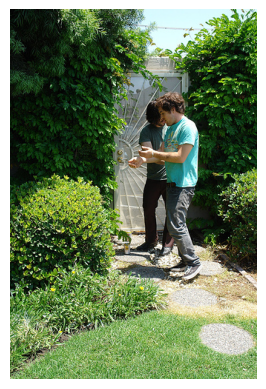

In [ ]:
def plot_image_from_bytes(image_bytes):
    img = Image.open(BytesIO(image_bytes))
    plt.imshow(img)
    plt.axis('off')  # Optional: Turn off axis if you don't want them
    plt.show()

image = dataset["image"][0]
plot_image_from_bytes(image)


Now every single image is saved in a separate file (./drive/MyDrive/stitching/train/images/) while all the captions are saved in a pandas dataframe (./drive/MyDrive/stitching/train/captions/captions.pkl)

# Image Reconstruction

I thought about using a U-Net but given the fact that it has residual inputs then it is not possible to just use it partially. The huggin face one cannot be used since it puts residual connections.
L'attention block prende molti GB di VRAM

## Model From Scratch

In [18]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, inChannels, outChannels, down=True, use_act = True, **kwargs):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, **kwargs) if down else nn.ConvTranspose2d(inChannels, outChannels, **kwargs),
            nn.InstanceNorm2d(outChannels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )


    def forward(self, x):
        return self.conv(x)


In [19]:
class DownBlocks(nn.Module):
    def __init__(self, imgChannels, numFeatures = 64):
      super(DownBlocks, self).__init__()
      self.initial = nn.Sequential(
            nn.Conv2d(imgChannels, numFeatures, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )
      self.downBlocks = nn.ModuleList([   #for downsampling
            ConvBlock(numFeatures, numFeatures*2, kernel_size = 3, stride = 2, padding = 1),
            ConvBlock(numFeatures*2, numFeatures*4,kernel_size = 3, stride = 2, padding = 1 )

        ])


    def forward(self, x):
        x = self.initial(x)
        for layer in self.downBlocks:
            x = layer(x)
        #print(x.shape) torch.Size([2, 36, 64, 64])
        return x


    def saveWeights(self, optimizer, filename, epoch = 0):
      print(f"=> Saving DownBlock to {filename}DownBlock.pth")
      checkpointDown = {
        "state_dict": self.downBlocks.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }

      #print(checkpointDown)
      torch.save(checkpointDown, f"{filename}DownBlock.pth")
      print(f"=> Done saving DownBlock to {filename}DownBlock.pth")


    def loadWeights(self, checkpoint_file, optimizer,  lr = 0.001, checkpointDown_file = None, checkpointUp_file = None):
      print("=> Loading Checkpoints")
      if checkpointDown_file is not None:
        print(f"=> Loading DownBlock from {checkpointDown_file}")
        checkpointDown = torch.load(checkpointDown_file, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.downBlocks.load_state_dict(checkpointDown["state_dict"])
        optimizer.load_state_dict(checkpointDown["optimizer"])

      else:
        print(f"=> Loading DownBlock from {checkpoint_file}DownBlock.pth")
        checkpoint = torch.load(f"{checkpoint_file}DownBlock.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.downBlocks.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])



In [20]:
class UpBlocks(nn.Module):
    def __init__(self, imgChannels, numFeatures = 64):
      super(UpBlocks, self).__init__()
      self.upBlocks = nn.ModuleList([
            ConvBlock(numFeatures * 4, numFeatures  * 2, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            ConvBlock(numFeatures * 2, numFeatures * 1, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

        ])

      self.last = nn.Conv2d(numFeatures * 1, imgChannels, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect")

    def forward(self, x):
        for layer in self.upBlocks:
            x = layer(x)
        return torch.tanh(self.last(x))


    def saveWeights(self, optimizer, filename, epoch = 0):
      print(f"=> Saving UpBlock to {filename}UpBlock.pth")
      checkpointUp = {
        "state_dict": self.upBlocks.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }
      torch.save(checkpointUp, f"{filename}UpBlock.pth")
      print(f"=> Done saving UpBlock to {filename}UpBlock.pth")


    def loadWeights(self, checkpoint_file, optimizer,  lr = 0.001, checkpointDown_file = None, checkpointUp_file = None):
      print("=> Loading Checkpoints")
      if checkpointUp_file is not None:
        print(f"=> Loading UpBlock from {checkpointUp_file}")
        checkpointUp = torch.load(checkpointUp_file, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.upBlocks.load_state_dict(checkpointUp["state_dict"])
        optimizer.load_state_dict(checkpointUp["optimizer"])

      else:
        print(f"=> Loading UpBlock from {checkpoint_file}UpBlock.pth")
        checkpoint = torch.load(f"{checkpoint_file}UpBlock.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.upBlocks.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

In [21]:
class UNet(nn.Module):
  def __init__(self, imgChannels, numFeatures = 64):
    super(UNet, self).__init__()
    self.downBlocks = DownBlocks(imgChannels, numFeatures=numFeatures)
    self.upBlocks = UpBlocks(imgChannels, numFeatures=numFeatures)




  def forward(self, x):

    x = self.downBlocks(x)
    #print(x.shape)
    x = self.upBlocks(x)
    #print(x.shape)

    return x




  def saveWeights(self, optimizer, modelName, epoch = 0):
    #save in two different state dictionaries downblocks and upblocks
    print(f"=> Saving checkpoint to {modelName}.pth")
    checkpoint = {
        "state_dict": self.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }
    torch.save(checkpoint, f"{modelName}.pth")
    print("=> Done saving checkpoint to", modelName)





  def loadWeights(self, modelName, optimizer = None,  lr = 0.001):
    #load from two different state dictionaries downblocks and upblocks

    print("=> Loading Checkpoint from", modelName)
    checkpoint = torch.load(f"{modelName}.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
    self.load_state_dict(checkpoint["state_dict"])
    if optimizer is not None:
      optimizer.load_state_dict(checkpoint["optimizer"])

      for param_group in optimizer.param_groups:
          param_group["lr"] = lr
      print("=> Done loading checkpoint from", modelName)









### Test

In [24]:
imgChannels = 3
imgSize = 256
x = torch.randn((2, imgChannels, imgSize, imgSize))
model = UNet(imgChannels, 9)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
print(model(x).shape)



torch.Size([2, 3, 256, 256])


In [27]:
if COLAB:
    checkpointsDir = "drive/MyDrive/stitching/checkpoints"
else:
    checkpointsDir = "./checkpoints/imageReconstructionEndToEnd"

print(checkpointsDir)

./checkpoints/imageReconstructionEndToEnd


In [25]:
!ls

checkpoints  env.yaml  readCaptions.ipynb  README.md  stitching.ipynb  train


In [28]:
checkPointUNet = f"{checkpointsDir}/UNetWeights"
checkPointTest = f"{checkPointUNet}/Test"

#model.saveWeights(optimizer,checkPointTest)
print(model(x).shape)

torch.Size([2, 3, 256, 256])


In [ ]:
loadCheckPoint = f"{checkpointsDir}/UNetWeights/firstUnet"
down = DownBlocks(imgChannels, numFeatures=4)
up = UpBlocks(imgChannels, numFeatures=4)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))

down.loadWeights(loadCheckPoint, optimizer)
up.loadWeights(loadCheckPoint, optimizer)

modelCombined = UNet(imgChannels, 4)
optimizer = optim.Adam(modelCombined.parameters(), lr=0.001, betas=(0.5, 0.999))
modelCombined.loadWeights(loadCheckPoint, optimizer)


## Dataloader


In [29]:
from PIL import Image
from torch.utils.data import Dataset
import os
import numpy as np
import torch
import albumentations as transforms
from albumentations.pytorch import ToTensorV2

In [30]:
class Flickr30k(Dataset):
    def __init__(self,
                  imagePath = flickrImagePath,
                  captionPath = None,
                  transform=transforms.Compose([
                        transforms.Resize(height = 32, width = 32),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ]),
                 targetImageSize = 32
        ):
        super(Dataset, self).__init__()
        self.path = imagePath
        self.data = os.listdir(self.path)

        print(f"Reading image data from: {self.path}")

        if targetImageSize != 32:
           transform=transforms.Compose([
                        transforms.Resize(height = targetImageSize, width = targetImageSize),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])

        self.transform = transform

        self.imageData = [image for image in self.data if os.path.isfile(os.path.join(self.path, image))]

        self.lenImageData = len(self.data)


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):

      #image  = Image.open(os.path.join(self.path, self.imageData[index % self.lenImageData])).convert('RGB')
      image  = Image.open(os.path.join(self.path, self.imageData[index])).convert('RGB')
      image = np.array(image)

      if self.transform is not None:
            image = self.transform(image = image)

            image = image["image"].float()

      return image






## Train Image Reconstruction


In [32]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split



from torchvision.utils import save_image
from time import time

import numpy as np


from PIL import Image
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import os


In [44]:
def UNet_trainFN(model, loaderTrain, loaderVal, optimizer, mse, epoch, scalar, dataset):
  """
  train for a single epoch
  """
  print("Training Model\n")
  loop = tqdm(loaderTrain, leave=True)
  step = 0
  device = "cuda" if torch.cuda.is_available() else "cpu"

  total_train_loss = 0.0

  model.train()

  for idx, image in enumerate(loop):

    realImage = image.to(device)

    with torch.cuda.amp.autocast_mode.autocast():
      generatedImage = model(realImage)

      loss = mse(realImage, generatedImage)

    total_train_loss += loss.item()

    avg_train_loss = total_train_loss / (idx + 1)  # Calculate average loss up to the current iteration
    loop.set_postfix(Loss=avg_train_loss, epoch=epoch)




    optimizer.zero_grad()
    scalar.scale(loss).backward()
    scalar.step(optimizer)
    scalar.update()

    loop.set_postfix(Loss = loss.item(), epoch = epoch)
  if loaderVal is not None:

    print("Validating Model\n")
    loop_val = tqdm(loaderVal, leave=True)

    model.eval()
    total_val_loss = 0.0


    with torch.no_grad():
        for idx, val_image in enumerate(loop_val):
            val_realImage = val_image.to(device)

            val_generatedImage = model(val_realImage)

            val_loss = mse(val_realImage, val_generatedImage)
            total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / (idx + 1)  # Calculate average loss up to the current iteration
            loop_val.set_postfix(Val_Loss=avg_val_loss, epoch=epoch)

        avg_val_loss = total_val_loss / len(loaderVal)
        loop_val.set_postfix(Val_Loss=avg_val_loss, epoch=epoch)


    model.train()






In [60]:
#parameters
epochs = 8
imgChannels = 3
imgSize = 299
numFeatures = 4
learningRate = 2e-4
batchSize = 8
numWorkers = 2

unetModelName = "firstUnet"
checkpointsDir = "./checkpoints/imageReconstructionEndToEnd"
pathUNetWeights = f"{checkpointsDir}/{unetModelName}"
print(f"Model Path: {pathUNetWeights}")

Model Path: ./checkpoints/imageReconstructionEndToEnd/firstUnet


In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")
UNetModel = UNet(imgChannels=imgChannels, numFeatures = numFeatures).to(device)
optimizer = optim.Adam(UNetModel.parameters(), lr=learningRate, betas=(0.5, 0.999))
MSE = nn.MSELoss()
epochCheckpoint = 0
dataset = Flickr30k(imagePath = flickrImagePath, captionPath = None, targetImageSize = imgSize)

Scalar = torch.cuda.amp.grad_scaler.GradScaler()

Training on: cuda
Reading image data from: ./train/images


In [57]:
datasetSize = len(dataset)
splitRatio = 0.8

trainSize = int(datasetSize * splitRatio)
valSize = datasetSize - trainSize

train_dataset, val_dataset = random_split(dataset, [trainSize, valSize])


In [58]:
train_UNet = True
load_UNet = True
fullLoader = DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers, pin_memory=True)
loaderTrain = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers, pin_memory=True)
loaderVal = DataLoader(val_dataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers, pin_memory=True)

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")
if load_UNet:
    #check if exists
  if os.path.exists(f"{pathUNetWeights}.pth"):
    print("Loading Model Weights")
    UNetModel.loadWeights(pathUNetWeights, optimizer, lr = learningRate)
  else:
    print(f"No Model Found in {pathUNetWeights}")
  if train_UNet:
    for epoch in range(epochs):
      UNet_trainFN(UNetModel, loaderTrain, loaderVal, optimizer, MSE, epoch, Scalar, dataset)
      #save the model
      UNetModel.saveWeights(optimizer, pathUNetWeights, epoch)

Training on: cuda
No Model Found in ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:27<00:00, 35.55it/s, Loss=0.0383, epoch=0]


Validating Model



100%|██████████| 776/776 [00:20<00:00, 37.16it/s, Val_Loss=0.0398, epoch=0]


=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:32<00:00, 33.63it/s, Loss=0.0189, epoch=1]


Validating Model



100%|██████████| 776/776 [00:19<00:00, 39.89it/s, Val_Loss=0.0314, epoch=1]


=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:19<00:00, 38.88it/s, Loss=0.0307, epoch=2]


Validating Model



100%|██████████| 776/776 [00:19<00:00, 40.24it/s, Val_Loss=0.0286, epoch=2]


=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:19<00:00, 39.25it/s, Loss=0.0182, epoch=3]


Validating Model



100%|██████████| 776/776 [00:18<00:00, 41.37it/s, Val_Loss=0.0255, epoch=3]


=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:19<00:00, 39.25it/s, Loss=0.0278, epoch=4]


Validating Model



100%|██████████| 776/776 [00:18<00:00, 41.17it/s, Val_Loss=0.0246, epoch=4]


=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:18<00:00, 39.43it/s, Loss=0.0228, epoch=5]


Validating Model



100%|██████████| 776/776 [00:18<00:00, 41.32it/s, Val_Loss=0.023, epoch=5] 


=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:21<00:00, 38.20it/s, Loss=0.0188, epoch=6]


Validating Model



100%|██████████| 776/776 [00:20<00:00, 38.57it/s, Val_Loss=0.0233, epoch=6]


=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet
Training Model



100%|██████████| 3102/3102 [01:20<00:00, 38.68it/s, Loss=0.0202, epoch=7]


Validating Model



100%|██████████| 776/776 [00:19<00:00, 40.27it/s, Val_Loss=0.0211, epoch=7]

=> Saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet.pth
=> Done saving checkpoint to ./checkpoints/imageReconstructionEndToEnd/firstUnet


In [47]:
checkpoint = torch.load("drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet.pth'

In [ ]:
print(checkpoint["state_dict"].keys())

odict_keys(['downBlocks.initial.0.weight', 'downBlocks.initial.0.bias', 'downBlocks.downBlocks.0.conv.0.weight', 'downBlocks.downBlocks.0.conv.0.bias', 'downBlocks.downBlocks.1.conv.0.weight', 'downBlocks.downBlocks.1.conv.0.bias', 'upBlocks.upBlocks.0.conv.0.weight', 'upBlocks.upBlocks.0.conv.0.bias', 'upBlocks.upBlocks.1.conv.0.weight', 'upBlocks.upBlocks.1.conv.0.bias', 'upBlocks.last.weight', 'upBlocks.last.bias'])


In [ ]:
#load another model with the same weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")
UNetModel2 = UNet(imgChannels=imgChannels, numFeatures = numFeatures).to(device)
optimizer2 = optim.Adam(UNetModel2.parameters(), lr=learningRate, betas=(0.5, 0.999))
UNetModel2.loadWeights(pathUNetWeights, optimizer2, epochCheckpoint)


Training on: cpu
=> Loading Checkpoint from drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet
=> Done loading checkpoint from drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet


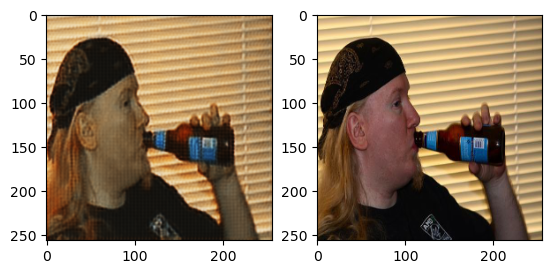

In [48]:
import matplotlib.pyplot as plt
    #plot them on the same line

image = next(iter(loaderVal))[0]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(UNetModel(image.to("cuda")).to("cpu").detach().permute(1,2,0) * 0.5 + 0.5)
axarr[1].imshow(np.array(image.permute(1,2,0)) * 0.5 + 0.5)
plt.show()

In [ ]:
transform=transforms.Compose([
                        transforms.Resize(height = 256, width = 256),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])

image  = Image.open("./home.jpg").convert('RGB')
image = np.array(image)

image = transform(image = image)

image = image["image"].float()

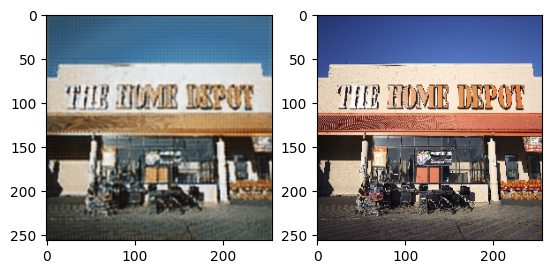

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#UNetModel = UNet(imgChannels=imgChannels, numFeatures = 4).to(device)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(UNetModel(image.to(device)).to("cpu").detach().permute(1,2,0) * 0.5 + 0.5)
axarr[1].imshow(np.asarray(image.permute(1,2,0)) * 0.5 + 0.5)
plt.show()

#

# Image Captioning



## Model

In [95]:
import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np


In [96]:
class EncoderCNN(nn.Module):
    def __init__(self, embedSize, trainCNN = False):
        super(EncoderCNN, self).__init__()
        self.trainCNN = False
        self.embedSize = embedSize

        self.inception = models.inception_v3(pretrained = True, aux_logits = True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embedSize)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.trainCNN



    def forward(self, images):
        features = self.inception(images)[0]


        x = self.relu(features)
        x = self.dropout(x)

        return x


In [97]:
class DecoderRNN(nn.Module):
    def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
        super(DecoderRNN, self).__init__()

        self.embed = nn.Embedding(vocabSize, embedSize)
        self.lstm = nn.LSTM(embedSize, hiddenSize, numLayers)
        self.linear = nn.Linear(hiddenSize, vocabSize)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, features, captions, captionLengths = 50):
        embeddings = self.dropout(self.embed(captions))


        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim = 0)

        output, _ = self.lstm(embeddings)

        output = self.linear(output)


        return output

In [98]:
class CNNtoRNN(nn.Module):
    def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embedSize=embedSize)
        self.decoderRNN = DecoderRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers)

    def forward (self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)

        return outputs

    def captionImage(self, image, vocabulary, maxLenght=50):
        resultCaption = []

        #TODO AGGIUNGERE LA POSSIBILITÀ DI FARE AUTOCOMPLETAMENTO     

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(maxLenght):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                print(output)
                predicted = output.argmax(0)
                resultCaption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.intToString[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.intToString[idx] for idx in resultCaption]
            



    def saveWeights(self, optimizer, modelName, epoch = 0):
        #save in two different state dictionaries downblocks and upblocks
        print(f"=> Saving checkpoint to {modelName}.pth")
        checkpoint = {
            "state_dict": self.state_dict(),
            "optimizer":  optimizer.state_dict(),
            "epoch": epoch
            }
        torch.save(checkpoint, f"{modelName}.pth")
        print("=> Done saving checkpoint to", modelName)





    def loadWeights(self, modelName, optimizer = None,  lr = 0.001):
      #load from two different state dictionaries downblocks and upblocks

      print("=> Loading Checkpoint from", modelName)
      checkpoint = torch.load(f"{modelName}.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
      self.load_state_dict(checkpoint["state_dict"])
      if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])

      for param_group in optimizer.param_groups:
          param_group["lr"] = lr
      print("=> Done loading checkpoint from", modelName)



## Dataset


In [99]:
import pandas as pd
import os
import spacy        #tokenizer
import torch
from  torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import random
import numpy as np

spacyEng = spacy.load("en_core_web_sm")

In [100]:
class Vocabulary():
    def __init__(self, freqThreshold):
        self.freqThreshold = freqThreshold
        self.intToString = {0: "<PAD>",
                            1: "<SOS>",
                            2: "<EOS>",
                            3: "<UNK>"}
        self.stringToInt = {"<PAD>": 0,
                            "<SOS>": 1,
                            "<EOS>": 2,
                            "<UNK>": 3}
    def __len__(self):
        return len(self.intToString)

    @staticmethod
    def tokenizerEng(text):
        return [tok.text.lower() for tok in spacyEng.tokenizer(text)]


    def buildVocabulary(self, captions):
        frequencies = {}
        index = 4   #we already have used the 0...3 indexed

        for caption in captions:
            for word in self.tokenizerEng(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freqThreshold:
                    self.intToString[index] = word
                    self.stringToInt[word] = index
                    index += 1


    def numericalize(self, caption):
        return [self.stringToInt[word] if word in self.stringToInt
                else self.stringToInt["<UNK>"]
                for word in self.tokenizerEng(caption)]


In [101]:
class FlickrCaptioning(Dataset):

  def __init__(self, rootDir, captionsPath,
               transform=transforms.Compose([
                        transforms.Resize(height = 300, width = 300),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ]), targetImageSize = 300,
               freqThreshold = 5, numberOfCaptions = 5, 
               ignorePhrase = "a man in a", numberOfSamples = None):

    if numberOfCaptions > 5:
      print("Max number of captions is 5. Setting 5.")
      numberOfCaptions = 5

    self.rootDir = rootDir
    self.captionsPath = captionsPath
    self.numberOfCaptions = numberOfCaptions
    

    #read df from pickle

    self.df = pd.read_pickle(captionsPath)  #filename, img_id, caption

    if numberOfSamples is None:
      self.numberOfSamples = len(self.df)
    else:
      self.numberOfSamples = numberOfSamples


    self.transform = transform
    if targetImageSize != 256:
      transform=transforms.Compose([
                        transforms.Resize(height = targetImageSize, width = targetImageSize),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])



    self.vocab = Vocabulary(freqThreshold)

    allCaptions = []
    flattenCaption = [] #used for building vocabulary
    for caption in self.df["caption"]:
        allCaptions.append(caption.tolist())
        flattenCaption.extend(caption)


    self.vocab.buildVocabulary(flattenCaption)

    #create empty dataframe
    self.preProcessedCaptions = {}

    prob = 0.2
    counter = 0



    for index in range(self.numberOfSamples):
        self.preProcessedCaptions[index] = []
        internalCounter = 0  #some images have 5 captions that always start with "a man in a". I'll let the last one of them pass
        for caption in allCaptions[index]:

            if caption.lower().startswith(ignorePhrase):
                if random.random() > prob:
                    counter += 1
                    internalCounter += 1
                    if internalCounter < numberOfCaptions:
                      continue
            numericalizedCaption = [self.vocab.stringToInt["<SOS>"]]
            numericalizedCaption.extend(self.vocab.numericalize(caption))
            numericalizedCaption.append(self.vocab.stringToInt["<EOS>"])
            self.preProcessedCaptions[index].append(torch.tensor(numericalizedCaption))
    print(f"Number of captions removed: {counter} that started with \"{ignorePhrase}\"")


  def __len__(self):
    return self.numberOfSamples

  def __getitem__(self, index):

    """
    Returns image and a list of numericalized captions in a list
    (in case there is one caption it will be a list of a single list of numericalized captions)
    """
    index = index % len(self.df)
    imageName = self.df["filename"][index]
    #captions = self.df["caption"][index].tolist()

    image = Image.open(os.path.join(self.rootDir, imageName)).convert("RGB")
    #convert to numpy

    image = np.array(image)

    if self.transform is not None:
      image = self.transform(image = image)

      image = image["image"].float()

    return image, self.preProcessedCaptions[index]
  



In [102]:
class MyCollate:
    def __init__(self, padIDX):
      self.padIDX = padIDX
    def __call__(self, batch):
      imgs = [item[0].unsqueeze(0) for item in batch]
      imgs = torch.cat(imgs, dim=0)

      targets = [random.choice(item[1]) for item in batch]
      targets = pad_sequence(sequences=targets, batch_first=False, padding_value=self.padIDX)

      return imgs, targets

## Train Image Captioning

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim


from tqdm import tqdm

In [104]:
#take a random image and caption it
def plotAndCaption(model):

  #take random image from the loader
  for batch_idx, (imgs, captions) in enumerate(loader):
    image = imgs[0]
    #add a dimension
    image = image.unsqueeze(0).to(device)
    captionT = ""
    for idx in captions[:, :1]:
      captionT += dataset.vocab.intToString[idx.item()] + " "
    

    print(image.shape)
    break


  model.eval()
  caption = model.captionImage(image, dataset.vocab)
  print(caption)
  print(f"The true caption is: {captionT}")
  plt.imshow(image[0].permute(1, 2, 0).to("cpu") * 0.5 + 0.5)
  plt.show()


In [105]:
plotAndCaption(model)

NameError: name 'model' is not defined

In [106]:
plotAndCaption(model=model)

NameError: name 'model' is not defined

In [107]:
#create a tensor whose only value is the one given by dataset.vocab.stringToInt["<SOS>"]


In [114]:
def fullImageCaptioning_trainFN(model, loader, optimizer, criterion, device, epoch):
  model.train()
  loop = tqdm(loader, leave = True)

  lossAvg = 0

  for batch_idx, (imgs, captions) in enumerate(loop):
    model.train()


      
    imgs = imgs.to(device = device)
    captions = captions.to(device = device)

    
    outputs = model(imgs, captions[:-1])
    


    loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))


    """
    #random int
    randInt = torch.randint(1, len(captions) , size = (1,1))[0][0].item()
    truncatedCaptions = captions[:randInt]
    outputs = model(imgs, t runcatedCaptions[:-1])

    loss = criterion(outputs.reshape(-1, outputs.shape[2]), truncatedCaptions.reshape(-1))
    """
    """
    CAMBIARE IL METODO DI TRAINING E FARGLI PREDIRE ANCHE GLI ELEMENTI INTEMEZZI ALLA CAPTION
    """
   # print("PRINTING OUTPUTS")
   # print(outputs)
   # print(outputs.shape)

   # print("PRINTING CAPTIONS")
   # print(captions)
   # print(captions.shape)

    lossAvg += loss.item()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss = loss.item(), lossAvg = lossAvg/(batch_idx+1), epoch = epoch)



In [109]:
embedSize = 512
hiddenSize = 512

numLayers = 2
learningRate = 3e-4
numEpoch = 100

In [110]:
dataset = FlickrCaptioning(rootDir = "train/images", captionsPath = "./train/captions/captions.pkl", targetImageSize = 299, numberOfCaptions= 5)
loader = DataLoader(dataset = dataset, batch_size = 2, shuffle = True, collate_fn = MyCollate(padIDX = dataset.vocab.stringToInt["<PAD>"]), pin_memory=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
vocabSize = len(dataset.vocab)
print(f"Vocab size: {vocabSize}")


Number of captions removed: 4511 that started with "a man in a"
Using cuda
Vocab size: 7623


In [111]:
model = CNNtoRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers).to(device=device)
imageCaptioninglName = "noManIn"
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stringToInt["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learningRate)

/home/shadow2030/miniconda3/envs/stitching/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shadow2030/miniconda3/envs/stitching/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

pathImageCaptioningWeights = f"./checkpoints/imageCaptioningEndToEnd/{imageCaptioninglName}"
loadModel = True
saveModel = False
trainModel = True
if loadModel:
  model.loadWeights(pathImageCaptioningWeights, optimizer = optimizer,  lr = learningRate)
  model.eval()

  plotAndCaption(model)


if trainModel:
  for epoch in range(numEpoch):

    model.eval()
    #plotAndCaption(model)

    fullImageCaptioning_trainFN(model = model, loader = loader, optimizer = optimizer, criterion = criterion, device = device, epoch = epoch)
    if saveModel:
      model.saveWeights(optimizer, pathImageCaptioningWeights, epoch = epoch)


    model.eval()
    plotAndCaption(model)

  """
  Sembra che non riesca ad essere influenzato dalla immagine.
  A questo punto possiamo provare a cambiare il modo di addestramento:
  anzichè fare la prediciton dell'ultimo token, lo facciamo a partire da un elemento a caso
  della caption.

  PRIMA CONTROLLARE CHE COSA VIENE ESATTAMENTE PASSATO COME INPUT NELLA FUNZIONE DI TRAINIG
  """



None


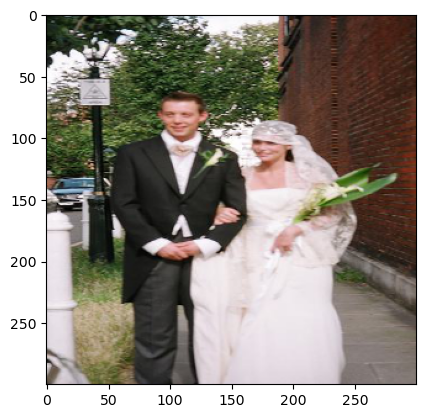

In [ ]:
model.eval()

print(model.captionImage(dataset[45][0].to(device).unsqueeze(0), dataset.vocab))


#plot image

plt.imshow(dataset[45][0].permute(1, 2, 0) * 0.5 + 0.5)
plt.show()


# Stitching

## Dataset

In [19]:
import pandas as pd
import os
import spacy        #tokenizer
import torch
from  torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import random
import numpy as np

import gc

spacyEng = spacy.load("en_core_web_sm")






TEST = False

In [20]:
class Vocabulary():
    def __init__(self, freqThreshold):
        self.freqThreshold = freqThreshold
        self.intToString = {0: "<PAD>",
                            1: "<SOS>",
                            2: "<EOS>",
                            3: "<UNK>"}
        self.stringToInt = {"<PAD>": 0,
                            "<SOS>": 1,
                            "<EOS>": 2,
                            "<UNK>": 3}
    def __len__(self):
        return len(self.intToString)

    @staticmethod
    def tokenizerEng(text):
        return [tok.text.lower() for tok in spacyEng.tokenizer(text)]


    def buildVocabulary(self, captions):
        frequencies = {}
        index = 4   #we already have used the 0...3 indexed

        for caption in captions:
            for word in self.tokenizerEng(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freqThreshold:
                    self.intToString[index] = word
                    self.stringToInt[word] = index
                    index += 1


    def numericalize(self, caption):
        return [self.stringToInt[word] if word in self.stringToInt
                else self.stringToInt["<UNK>"]
                for word in self.tokenizerEng(caption)]


In [104]:
class FlickrCaptioning(Dataset):

  def __init__(self, rootDir, captionsPath,
               transform=transforms.Compose([
                        transforms.Resize(height = 300, width = 300),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ]), targetImageSize = 300,
               freqThreshold = 5, numberOfCaptions = 5, 
               ignorePhrase = "a man in a", numberOfSamples = None, disalignCaptionImage = False):

    if numberOfCaptions > 5:
      print("Max number of captions is 5. Setting 5.")
      numberOfCaptions = 5

    self.rootDir = rootDir
    self.captionsPath = captionsPath
    self.numberOfCaptions = numberOfCaptions
    

    #read df from pickle

    self.df = pd.read_pickle(captionsPath)  #filename, img_id, caption

    if numberOfSamples is None:
      self.numberOfSamples = len(self.df)
    else:
      self.numberOfSamples = numberOfSamples


    self.transform = transform
    if targetImageSize != 256:
      transform=transforms.Compose([
                        transforms.Resize(height = targetImageSize, width = targetImageSize),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])



    self.vocab = Vocabulary(freqThreshold)

    allCaptions = []
    flattenCaption = [] #used for building vocabulary
    for caption in self.df["caption"]:
        allCaptions.append(caption.tolist())
        flattenCaption.extend(caption)


    self.vocab.buildVocabulary(flattenCaption)

    #create empty dataframe
    self.preProcessedCaptions = {}

    prob = 0.2
    counter = 0



    for index in range(self.numberOfSamples):
        self.preProcessedCaptions[index] = []
        internalCounter = 0  #some images have 5 captions that always start with "a man in a". I'll let the last one of them pass
        for caption in allCaptions[index]:

            if caption.lower().startswith(ignorePhrase):
                if random.random() > prob:
                    counter += 1
                    internalCounter += 1
                    if internalCounter < numberOfCaptions:
                      continue
            numericalizedCaption = [self.vocab.stringToInt["<SOS>"]]
            numericalizedCaption.extend(self.vocab.numericalize(caption))
            numericalizedCaption.append(self.vocab.stringToInt["<EOS>"])
            self.preProcessedCaptions[index].append(torch.tensor(numericalizedCaption))
    print(f"Number of captions removed: {counter} that started with \"{ignorePhrase}\"")

    if disalignCaptionImage:
       #shuffle preprocessed captions
      print("Disaligning captions with respect to images")
      random.shuffle(self.preProcessedCaptions)



  def __len__(self):
    return self.numberOfSamples

  def __getitem__(self, index):

    """
    Returns image and a list of numericalized captions in a list
    (in case there is one caption it will be a list of a single list of numericalized captions)
    """
    index = index % len(self.df)
    imageName = self.df["filename"][index]
    #captions = self.df["caption"][index].tolist()

    image = Image.open(os.path.join(self.rootDir, imageName)).convert("RGB")
    #convert to numpy

    image = np.array(image)

    if self.transform is not None:
      image = self.transform(image = image)

      image = image["image"].float()

    return image, self.preProcessedCaptions[index]
  



In [22]:
class MyCollate:
    def __init__(self, padIDX):
      self.padIDX = padIDX
    def __call__(self, batch):
      imgs = [item[0].unsqueeze(0) for item in batch]
      imgs = torch.cat(imgs, dim=0)

      targets = [random.choice(item[1]) for item in batch]
      targets = pad_sequence(sequences=targets, batch_first=False, padding_value=self.padIDX)

      return imgs, targets

## Model

In [23]:
import pandas as pd

import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision.datasets.utils import download_url

import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np



import numpy as np


### Image Captioning Model

In [24]:
class EncoderCNN(nn.Module):
    def __init__(self, embedSize, trainCNN = False):
        super(EncoderCNN, self).__init__()
        self.trainCNN = False
        self.embedSize = embedSize

        self.inception = models.inception_v3(pretrained = True, aux_logits = True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embedSize)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.trainCNN



    def forward(self, images):
        features = self.inception(images)[0]


        x = self.relu(features)
        x = self.dropout(x)

        return x


In [67]:
class DecoderRNN(nn.Module):
    def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
        super(DecoderRNN, self).__init__()

        self.embed = nn.Embedding(vocabSize, embedSize)
        self.lstm = nn.LSTM(embedSize, hiddenSize, numLayers)
        self.linear = nn.Linear(hiddenSize, vocabSize)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, features, captions, hiddenStates = None,  captionLengths = 50):
        embeddings = self.dropout(self.embed(captions))

     
        if features is not None:
            embeddings = torch.cat((features.unsqueeze(0), embeddings), dim = 0)

        
        if hiddenStates is not None:
            output, (h, c)= self.lstm(embeddings, hiddenStates)
        else:

            output, (h, c) = self.lstm(embeddings)

        output = self.linear(output)


        return output, (h, c)

In [68]:
class CNNtoRNN(nn.Module):
    def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embedSize=embedSize)
        self.decoderRNN = DecoderRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers)

    def forward (self, images, captions):
        features = self.encoderCNN(images)
        outputs, (h, c) = self.decoderRNN(features, captions)

        return outputs

    def captionImage(self, image, vocabulary, maxLenght=50):
        resultCaption = []

        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(maxLenght):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                print(output)
                predicted = output.argmax(0)
                resultCaption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.intToString[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.intToString[idx] for idx in resultCaption]
            



    def saveWeights(self, optimizer, modelName, epoch = 0):
        #save in two different state dictionaries downblocks and upblocks
        print(f"=> Saving checkpoint to {modelName}.pth")
        checkpoint = {
            "state_dict": self.state_dict(),
            "optimizer":  optimizer.state_dict(),
            "epoch": epoch
            }
        torch.save(checkpoint, f"{modelName}.pth")
        print("=> Done saving checkpoint to", modelName)





    def loadWeights(self, modelName, optimizer = None,  lr = 0.001):
      #load from two different state dictionaries downblocks and upblocks

      print("=> Loading Checkpoint from", modelName)
      checkpoint = torch.load(f"{modelName}.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
      self.load_state_dict(checkpoint["state_dict"])
      if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        print("=> Done loading checkpoint from", modelName)



### Image Reconstruction Model

In [69]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, inChannels, outChannels, down=True, use_act = True, **kwargs):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, **kwargs) if down else nn.ConvTranspose2d(inChannels, outChannels, **kwargs),
            nn.InstanceNorm2d(outChannels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )


    def forward(self, x):
        return self.conv(x)


In [70]:
class DownBlocks(nn.Module):
    def __init__(self, imgChannels, numFeatures = 64):
      super(DownBlocks, self).__init__()
      self.initial = nn.Sequential(
            nn.Conv2d(imgChannels, numFeatures, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )
      self.downBlocks = nn.ModuleList([   #for downsampling
            ConvBlock(numFeatures, numFeatures*2, kernel_size = 3, stride = 2, padding = 1),
            ConvBlock(numFeatures*2, numFeatures*4,kernel_size = 3, stride = 2, padding = 1 )

        ])


    def forward(self, x):
        x = self.initial(x)
        for layer in self.downBlocks:
            x = layer(x)
        #print(x.shape) torch.Size([2, 36, 64, 64])
        return x


    def saveWeights(self, optimizer, filename, epoch = 0):
      print(f"=> Saving DownBlock to {filename}DownBlock.pth")
      checkpointDown = {
        "state_dict": self.downBlocks.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }

      #print(checkpointDown)
      torch.save(checkpointDown, f"{filename}DownBlock.pth")
      print(f"=> Done saving DownBlock to {filename}DownBlock.pth")


    def loadWeights(self, checkpoint_file, optimizer,  lr = 0.001, checkpointDown_file = None, checkpointUp_file = None):
      print("=> Loading Checkpoints")
      if checkpointDown_file is not None:
        print(f"=> Loading DownBlock from {checkpointDown_file}")
        checkpointDown = torch.load(checkpointDown_file, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.downBlocks.load_state_dict(checkpointDown["state_dict"])
        optimizer.load_state_dict(checkpointDown["optimizer"])

      else:
        print(f"=> Loading DownBlock from {checkpoint_file}DownBlock.pth")
        checkpoint = torch.load(f"{checkpoint_file}DownBlock.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.downBlocks.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])



In [71]:
class UpBlocks(nn.Module):
    def __init__(self, imgChannels, numFeatures = 64):
      super(UpBlocks, self).__init__()
      self.upBlocks = nn.ModuleList([
            ConvBlock(numFeatures * 4, numFeatures  * 2, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            ConvBlock(numFeatures * 2, numFeatures * 1, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

        ])

      self.last = nn.Conv2d(numFeatures * 1, imgChannels, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect")

    def forward(self, x):
        for layer in self.upBlocks:
            x = layer(x)
        return torch.tanh(self.last(x))


    def saveWeights(self, optimizer, filename, epoch = 0):
      print(f"=> Saving UpBlock to {filename}UpBlock.pth")
      checkpointUp = {
        "state_dict": self.upBlocks.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }
      torch.save(checkpointUp, f"{filename}UpBlock.pth")
      print(f"=> Done saving UpBlock to {filename}UpBlock.pth")


    def loadWeights(self, checkpoint_file, optimizer,  lr = 0.001, checkpointDown_file = None, checkpointUp_file = None):
      print("=> Loading Checkpoints")
      if checkpointUp_file is not None:
        print(f"=> Loading UpBlock from {checkpointUp_file}")
        checkpointUp = torch.load(checkpointUp_file, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.upBlocks.load_state_dict(checkpointUp["state_dict"])
        optimizer.load_state_dict(checkpointUp["optimizer"])

      else:
        print(f"=> Loading UpBlock from {checkpoint_file}UpBlock.pth")
        checkpoint = torch.load(f"{checkpoint_file}UpBlock.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.upBlocks.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

In [72]:
class UNet(nn.Module):
  def __init__(self, imgChannels, numFeatures = 64):
    super(UNet, self).__init__()
    self.downBlocks = DownBlocks(imgChannels, numFeatures=numFeatures)
    self.upBlocks = UpBlocks(imgChannels, numFeatures=numFeatures)




  def forward(self, x):

    x = self.downBlocks(x)
    #print(x.shape)
    x = self.upBlocks(x)
    #print(x.shape)

    return x




  def saveWeights(self, optimizer, modelName, epoch = 0):
    #save in two different state dictionaries downblocks and upblocks
    print(f"=> Saving checkpoint to {modelName}.pth")
    checkpoint = {
        "state_dict": self.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }
    torch.save(checkpoint, f"{modelName}.pth")
    print("=> Done saving checkpoint to", modelName)





  def loadWeights(self, modelName, optimizer = None,  lr = 0.001):
    #load from two different state dictionaries downblocks and upblocks

    print("=> Loading Checkpoint from", modelName)
    checkpoint = torch.load(f"{modelName}.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
    self.load_state_dict(checkpoint["state_dict"])
    if optimizer is not None:
      optimizer.load_state_dict(checkpoint["optimizer"])

      for param_group in optimizer.param_groups:
          param_group["lr"] = lr
      print("=> Done loading checkpoint from", modelName)









### Stitched Models

Output shape of UNet DownBlocks torch.Size([16, 75, 75])

Output shape of UNet UpBlocks torch.Size([3, 300, 300])

Output shape of CNNtoRNN encoder torch.Size([512])

Output final hidden state shape shape of CNNtoRNN decoder torch.Size([512])



In [165]:
class Text2Image(nn.Module):
    def __init__(self, 
            captioningModel,
            reconstructionModel,
            
                 ):
        super(Text2Image, self).__init__()

        #freeze the weights of the captioning model
        for param in captioningModel.parameters():
            param.requires_grad = False

        self.captioningModel = captioningModel.decoderRNN

        #freeze the weights of the reconstruction model
        for param in reconstructionModel.parameters():
            param.requires_grad = False

        self.reconstructionModel = reconstructionModel.upBlocks #input is 16 x 75 x 75 for each image



        #linear layer that maps 512 to 3x16x75x75
        self.linear = nn.Linear(512, 16*75*75)
    
    def forward(self, captions):
        #create empty tensor of size 512
        #check the batch size

        zeroImage = None

    
        output, (h, c) = self.captioningModel(zeroImage, captions)
        #h = h[-1]   #take the last layer hidden state
        #print(f"Hidden state: {h.shape}")
        h = h[-1]
        x = self.linear(h)
        #print(f"Hidden state -> X after linear: {x.shape}")
        x = x.view(-1, 16, 75, 75)
        #print(f"X after view: {x.shape}")


        
       
        x = self.reconstructionModel(x)
        #print(f"X after reconstruction: {x.shape}")

        return x
    

        

        

In [166]:
if TEST:

    CNNtoRNNmodel = CNNtoRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers).to(device=device)
    CNNtoRNNmodel.loadWeights(pathImageCaptioningWeights, optimizer = None,  lr = learningRate)

    stitchedModel = Text2Image(CNNtoRNNmodel, UNetModel).to(device)



In [167]:
if TEST:
    del CNNtoRNNmodel
    del stitchedModel

    gc.collect()

    torch.cuda.empty_cache()

    CNNtoRNNmodel = CNNtoRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers).to(device=device)
    CNNtoRNNmodel.loadWeights(pathImageCaptioningWeights, optimizer = None,  lr = learningRate)

    stitchedModel = Text2Image(CNNtoRNNmodel, UNetModel).to(device)

    for batch_idx, (imgs, captions) in enumerate(loader):
        stitchedModel = Text2Image(CNNtoRNNmodel, UNetModel).to(device)

        print(f"Image shape: {imgs.shape}")
        print(f"Caption shape: {captions.shape}")

        stitchedModel(captions.to(device))
        break




In [168]:
class Image2Text(nn.Module):
    def __init__(self, 
            captioningModel,
            reconstructionModel,
            
                 ):
        super(Image2Text, self).__init__()

        #freeze the weights of the captioning model
        for param in captioningModel.parameters():
            param.requires_grad = False

        self.captioningModel = captioningModel.decoderRNN

        #freeze the weights of the reconstruction model
        for param in reconstructionModel.parameters():
            param.requires_grad = False


        self.encoderImage = reconstructionModel.downBlocks

        self.linear = nn.Linear(16*75*75, 512)


    def forward(self, images, captions, hiddenStates = None):
        #captions is either a list of tokenized captions or shiould be an input of just <SOS> token
        features = self.encoderImage(images)
        features = features.view(-1, 16*75*75)
        

        features = self.linear(features)

        captions, (h, c) = self.captioningModel(features, captions, hiddenStates) #output, hidden 

        return captions, (h, c)





        



        

In [169]:
if TEST:
    del CNNtoRNNmodel
    del stitchedModel

    gc.collect()

    torch.cuda.empty_cache()

    CNNtoRNNmodel = CNNtoRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers).to(device=device)
    CNNtoRNNmodel.loadWeights(pathImageCaptioningWeights, optimizer = None,  lr = learningRate)

    stitchedModel = Text2Image(CNNtoRNNmodel, UNetModel).to(device)

    for batch_idx, (imgs, captions) in enumerate(loader):
        stitchedModel = Image2Text(CNNtoRNNmodel, UNetModel).to(device)

        print(f"Image shape: {imgs.shape}")
        print(f"Caption shape: {captions.shape}")

        print(stitchedModel(imgs.to(device), captions.to(device))[0].shape)
        break


## Train 

In [170]:
#instatiate the dataset
#instatiate the models
#define training function
#train the models in a cycle consistent manner


In [171]:


dataset = FlickrCaptioning(rootDir = "train/images", captionsPath = "./train/captions/captions.pkl", targetImageSize = 300, numberOfCaptions= 5)
batchSize = 2
loader = DataLoader(dataset = dataset, batch_size = batchSize, shuffle = True, collate_fn = MyCollate(padIDX = dataset.vocab.stringToInt["<PAD>"]), pin_memory=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
vocabSize = len(dataset.vocab)
print(f"Vocab size: {vocabSize}")



Number of captions removed: 4430 that started with "a man in a"
Using cuda
Vocab size: 7623


In [172]:

embedSize = 512
hiddenSize = 512

numLayers = 2
learningRate = 3e-4

CNNtoRNNmodel = CNNtoRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers).to(device=device)
imageCaptioninglName = "noManIn"

pathImageCaptioningWeights = f"./checkpoints/imageCaptioningEndToEnd/{imageCaptioninglName}"

CNNtoRNNmodel.loadWeights(pathImageCaptioningWeights, optimizer = None,  lr = learningRate)

/home/shadow2030/miniconda3/envs/stitching/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shadow2030/miniconda3/envs/stitching/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Loading Checkpoint from ./checkpoints/imageCaptioningEndToEnd/noManIn


In [173]:

imgChannels = 3
imgSize = 299
numFeatures = 4
learningRate = 2e-4

transform=transforms.Compose([
                        transforms.Resize(height = 300, width = 300),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])


pathUNetWeights = f"./checkpoints/imageReconstructionEndToEnd/firstUnet"
UNetModel = UNet(imgChannels=imgChannels, numFeatures = numFeatures).to(device)
UNetModel.loadWeights(pathUNetWeights, optimizer = None,  lr = learningRate)




=> Loading Checkpoint from ./checkpoints/imageReconstructionEndToEnd/firstUnet


In [174]:
if TEST:

    UNetModel.upBlocks(UNetModel.downBlocks(torch.randn(3, 300, 300).to("cuda"))).shape



    imgTest = dataset[0][0].unsqueeze(0).to(device)
    captionTest = dataset[0][1][0].to(device)
    captionTest2 = dataset[0][1][1].unsqueeze(0).to(device)


    print(imgTest.shape)
    print(captionTest.shape)




### Test


In [175]:
if TEST:
    #create a random 1d tensor of size 512
    x = torch.randn(512).unsqueeze(0).to(device).unsqueeze(0)
    x.shape

In [176]:
if TEST:
    CNNtoRNNmodel = CNNtoRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers).to(device=device)
    CNNtoRNNmodel.loadWeights(pathImageCaptioningWeights, optimizer = None,  lr = learningRate)

    CNNtoRNNmodel.eval()


    ciao = CNNtoRNNmodel(imgTest, captionTest.to(device)).argmax(1)
    CNNtoRNNmodel(imgTest, ciao).shape

In [177]:
if TEST:
    enc = CNNtoRNNmodel.encoderCNN(imgTest)
    dec = CNNtoRNNmodel.decoderRNN(enc, captionTest.to(device))
    print(captionTest.shape)

In [178]:
if TEST:
    print(f"Output shape of UNet DownBlocks {UNetModel.downBlocks(torch.randn(3, 300, 300).to(device)).shape}")
    print(f"Output shape of UNet UpBlocks {UNetModel.upBlocks(torch.randn(16, 75, 75).to(device)).shape}")

    print(f"Output shape of CNNtoRNN encoder {CNNtoRNNmodel.encoderCNN(torch.randn(3, 3, 300, 300).to(device)).shape}")
    print(f"Output shape of CNNtoRNN decoder {CNNtoRNNmodel.decoderRNN(enc, captionTest.to(device))[1].shape}")

    enc = torch.zeros(512).to(device)
    print(f"Output shape of CNNtoRNN decoder {CNNtoRNNmodel.decoderRNN(enc, captionTest.to(device))[1].shape}")

Output shape of UNet DownBlocks torch.Size([3, 16, 75, 75])

Output shape of UNet UpBlocks torch.Size([3, 3, 300, 300])

Output shape of CNNtoRNN encoder torch.Size([512])

Output shape of CNNtoRNN decoder torch.Size([20, 7623])


### Trainig Loop

In [179]:
#import optimizer
import torch.optim as optim

In [187]:
def cycleConsist_trainFN(image2TextModel, text2ImageModel, 
                         optimizerText2Image, optimizerImage2Text,
                         criterionImageReconstruction, criterionImageCaptioning,
                            loader, device, epoch): 
    
   image2TextModel.train()
   text2ImageModel.train()
   loop = tqdm(loader, leave = True)


   for batch_idx, (imgs, captions) in enumerate(loop):
      imgs = imgs.to(device)
      captions = captions.to(device) #USED FOR TEXT2IMAGE
      startOfSentence = torch.tensor([dataset.vocab.stringToInt["<SOS>"], dataset.vocab.stringToInt["<SOS>"]]).unsqueeze(0).to(device) #USED FOR IMAGE2TEXT


      #TRAINING IMAGE2TEXT2IMAGE
      middleCaptionsLogits = image2TextModel(imgs, startOfSentence)[0]
      middleCaptions = middleCaptionsLogits.argmax(2)
      #print(middleCaptions.shape)
      reconstructedImages = text2ImageModel(middleCaptions)
      #print(reconstructedImages.shape)

      lossImageReconstruction = criterionImageReconstruction(reconstructedImages, imgs)
      optimizerImage2Text.zero_grad()
      optimizerText2Image.zero_grad()
      lossImageReconstruction.backward()
      optimizerImage2Text.step()
      optimizerText2Image.step()


      #TRAINING TEXT2IMAGE2TEXT
      middleImages = text2ImageModel(captions)
      #print(f"Middle images shape: {middleImages.shape}")
      reconstructedCaptions, _ = image2TextModel(imgs, captions[:-1])
      #print(f"Reconstructed captions shape: {reconstructedCaptions.shape}")
      #print(f"Captions shape: {captions.shape}")

      lossImageCaptioning = criterionImageCaptioning(reconstructedCaptions.reshape(-1, reconstructedCaptions.shape[2]), captions.reshape(-1))
      
      
      
      optimizerImage2Text.zero_grad()
      optimizerText2Image.zero_grad()
      lossImageCaptioning.backward()
      optimizerImage2Text.step()
      optimizerText2Image.step()

      loop.set_postfix(lossImageReconstruction = lossImageReconstruction.item(), lossImageCaptioning = lossImageCaptioning.item(), epoch = epoch)


      













      #flow generale:
      #1. Fare image2Text e con l'output fare text2Image
      #2. Fare text2Image e con l'output fare image2Text
      #3. Calcolare la loss di entrambi i modelli

      

        



In [181]:
image2TextModel = Image2Text(CNNtoRNNmodel, UNetModel).to(device)
text2ImageModel = Text2Image(CNNtoRNNmodel, UNetModel).to(device)



In [182]:
image2TextModelName = "FirstImage2Text"
image2TextModelPath = f"./checkpoints/stitchedModels/{image2TextModelName}"

text2ImageModelName = "FirstText2Image"
text2ImageModelPath = f"./checkpoints/stitchedModels/{text2ImageModelName}"

In [183]:
optimizerText2Image = optim.Adam(text2ImageModel.linear.parameters(), lr = learningRate)
optimizerImage2Text = optim.Adam(image2TextModel.linear.parameters(), lr = learningRate)

criterionImageCaptioning = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stringToInt["<PAD>"])
criterionImageReconstruction = nn.MSELoss()

In [188]:
loadModel = False
saveModel = False
trainModel = True



if loadModel:
    image2TextModel.loadWeights(image2TextModelPath, optimizer = optimizerText2Image,  lr = learningRate)
    text2ImageModel.loadWeights(text2ImageModelPath, optimizer = optimizerImage2Text,  lr = learningRate)



numEpoch = 100

if trainModel:
    for epoch in range(numEpoch):
        cycleConsist_trainFN(image2TextModel, text2ImageModel, 
                         optimizerText2Image, optimizerImage2Text,
                         criterionImageReconstruction, criterionImageCaptioning,
                            loader, device, epoch)

        if saveModel:
            image2TextModel.saveWeights(optimizerText2Image, image2TextModelPath, epoch = epoch)
            text2ImageModel.saveWeights(optimizerImage2Text, text2ImageModelPath, epoch = epoch)
        



  1%|          | 163/15507 [00:14<23:16, 10.99it/s, epoch=0, lossImageCaptioning=3.01, lossImageReconstruction=0.61] 


KeyboardInterrupt: 

In [185]:
#check what are the trainable parameters
for name, param in image2TextModel.named_parameters():
    print(name, param.requires_grad)

captioningModel.embed.weight False
captioningModel.lstm.weight_ih_l0 False
captioningModel.lstm.weight_hh_l0 False
captioningModel.lstm.bias_ih_l0 False
captioningModel.lstm.bias_hh_l0 False
captioningModel.lstm.weight_ih_l1 False
captioningModel.lstm.weight_hh_l1 False
captioningModel.lstm.bias_ih_l1 False
captioningModel.lstm.bias_hh_l1 False
captioningModel.linear.weight False
captioningModel.linear.bias False
encoderImage.initial.0.weight False
encoderImage.initial.0.bias False
encoderImage.downBlocks.0.conv.0.weight False
encoderImage.downBlocks.0.conv.0.bias False
encoderImage.downBlocks.1.conv.0.weight False
encoderImage.downBlocks.1.conv.0.bias False
linear.weight True
linear.bias True


# Image as hidden state
https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch